# Replication: Sterling *etal*, 2016
## Introduction

This notebook attempts to replicate the following paper with [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Sterling, Nicholas W, et al. <a href=https://n.neurology.org/content/86/12/1143.short>Stage-dependent loss of cortical gyrification as Parkinson disease “unfolds”.</a> Neurology, vol. 86, no. 12, pp. 1143–1151, Mar. 2016. 
</div>

This study recruited 70 patients with PD without dementia and 70 control participants. Cortical local gyrification index (LGI) was compared between controls and PD subgroups based upon duration of illness. In the longitudinal cohort, PD<sub>L</sub> had significantly reduced overall gyrification, and bilaterally in the inferior parietal, postcentral, precentral, superior frontal, and superamarginal areas, compared to controls (*p* < 0.05). Longitudinally, loss of gyrification was accelerated in PD<sub>M</sub>, compared to controls. Demographic and clinical properties were as follows (table extracted from the paper):

<br>
<img src="demographics.png">

In [190]:
from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>"""
)

In [191]:
import datetime

print(f"This notebook was run on {datetime.datetime.now()}")

This notebook was run on 2022-08-23 23:55:30.241738


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort:

- Age at visit (to retrieve age)Demographics (to retrieve sex)
- Socio Economics (to retrieve education)
- MDS UPDRS Part III (to retrieve H&Y scores and UPDRS III values)
- Montreal Cognitive Assessment MoCA (to retrieve MMSE scores)
- PD Diagnosis History (to retrieve duration of illness)
- LEDD Concomitant Medication log (to retrieve LEDD values)
- Geriatric Depression Scale Short Version (to retrieve GDS scores instead of HAM scores)


We will use PPMI downloader to download these files from the PPMI database. If the files are already present, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [192]:
import os
import os.path as op
import ppmi_downloader
import warnings

warnings.filterwarnings("ignore")

data_dir = "data"
required_files = [
    "Age_at_visit.csv",
    "Demographics.csv",
    "Socio-Economics.csv",
    "MDS_UPDRS_Part_III.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv",
]

missing_files = [x for x in required_files if not op.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    print(f"Downloading missing files: {missing_files}")
    ppmi = ppmi_downloader.PPMIDownloader()
    ppmi.download_metadata(
        missing_files, destination_dir=data_dir, headless=False, timeout=600
    )

print(f"The following files are available: {required_files}")

The following files are available: ['Age_at_visit.csv', 'Demographics.csv', 'Socio-Economics.csv', 'MDS_UPDRS_Part_III.csv', 'Montreal_Cognitive_Assessment__MoCA_.csv', 'PD_Diagnosis_History.csv', 'LEDD_Concomitant_Medication_Log.csv', 'Geriatric_Depression_Scale__Short_Version_.csv']


### Cohort matching

### Utilities

In [193]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


visit2month = {
    "BL": 0,
    "V01": 3,
    "V02": 6,
    "V03": 9,
    "V04": 12,
    "V05": 18,
    "V06": 24,
    "V07": 30,
    "V08": 36,
    "V09": 42,
    "V10": 48,
    "V11": 54,
    "V12": 60,
    "V13": 72,
    "V14": 84,
    "V15": 96,
    "V16": 108,
    "V17": 120,
    "V18": 132,
    "V19": 144,
    "V20": 156,
}


def moca2mmse(moca_score):
    """Returns a MMSE score given MoCA score."""
    mapping = {
        1: 6,
        2: 9,
        3: 11,
        4: 12,
        5: 13,
        6: 14,
        7: 15,
        8: 15,
        9: 16,
        10: 17,
        11: 18,
        12: 18,
        13: 19,
        14: 20,
        15: 21,
        16: 22,
        17: 22,
        18: 23,
        19: 24,
        20: 25,
        21: 26,
        22: 26,
        23: 27,
        24: 28,
        25: 28,
        26: 29,
        27: 29,
        28: 30,
        29: 30,
        30: 30,
    }

    try:
        if math.isnan(moca_score):
            return np.nan
        else:
            return mapping[moca_score]
    except:
        return moca_score


def reformat_plot_labels(dist, ax, freq):
    ax.set_xticklabels([x.removesuffix(".0") for x in dist.index.astype(str)])
    for label in ax.xaxis.get_ticklabels():
        try:
            if int(label.get_text()) % freq != 0:
                label.set_visible(False)
        except:
            pass

### Duration of illness (DOI)

In [194]:
pddxdt = pd.read_csv(os.path.join(data_dir, "PD_Diagnosis_History.csv"))[
    ["PATNO", "EVENT_ID", "PDDXDT"]
]

print("PD Diagnosis\n\n" + pddxdt.groupby(["EVENT_ID"]).size().to_string())

PD Diagnosis

EVENT_ID
BL        4
SC     1216
V04       1


We will only use the PD diagnosis taken at screening since it is by far the most frequent.

In [195]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

pddxdt = pddxdt[(pddxdt["EVENT_ID"] == "SC") & (pddxdt["PDDXDT"].notna())]

pdxdur = pd.read_csv(
    os.path.join(data_dir, "MDS_UPDRS_Part_III.csv"), low_memory=False
)[["PATNO", "EVENT_ID", "INFODT"]]

PDDXDT_map = dict(zip(pddxdt["PATNO"].values, pddxdt["PDDXDT"].values))
pdxdur["PDDXDT"] = pdxdur["PATNO"].map(PDDXDT_map)

pdxdur["PDXDUR"] = pdxdur.apply(
    lambda row: relativedelta(parse(row["INFODT"]), parse(row["PDDXDT"])).years
    if row["PDDXDT"] is not np.nan
    else np.nan,
    axis=1,
)

pdxdur.drop(labels=["INFODT", "PDDXDT"], inplace=True, axis=1)

### PD subgroups
Study divided PD patients in subgroups based upon duration of illness, defined as the number of years since diagnosis. PD<sub>E</sub> (<1 year), PD<sub>M</sub> (1-5 years), and PD<sub>L</sub> (>5 years).

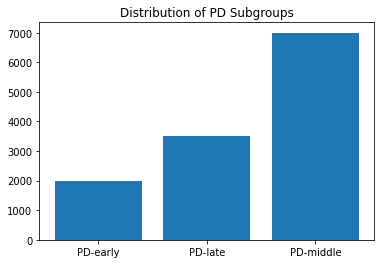

In [196]:
pdxdur["DOI"] = (
    pdxdur["PDXDUR"]
    .mask(pdxdur["PDXDUR"] < 1, "PD-early")
    .mask((pdxdur["PDXDUR"] >= 1) & (pdxdur["PDXDUR"] <= 5), "PD-middle")
    .mask(pdxdur["PDXDUR"] > 5, "PD-late")
)

fig, ax = plt.subplots()
dist = pdxdur.groupby(["DOI"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of PD Subgroups");

### Examination scores

### Mini-Mental State Examination (MMSE)
The study selected patients with MMSE score ≥26 (without dementia).

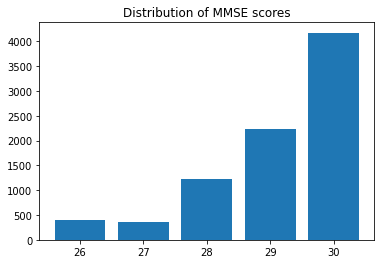

In [197]:
mmse = pd.read_csv(os.path.join(data_dir, "Montreal_Cognitive_Assessment__MoCA_.csv"))[
    ["PATNO", "EVENT_ID", "MCATOT"]
]
mmse["MMSETOT"] = mmse["MCATOT"].apply(moca2mmse)
mmse = mmse.drop(["MCATOT"], axis=1)
mmse = mmse[mmse["MMSETOT"] >= 26]

fig, ax = plt.subplots()
dist = mmse.groupby(["MMSETOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MMSE scores")
reformat_plot_labels(dist, ax, 1)

### Hoehn & Yahr (H&Y)

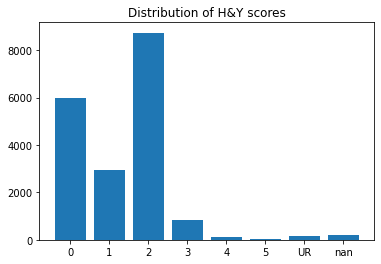

In [198]:
updrs3 = pd.read_csv(os.path.join(data_dir, "MDS_UPDRS_Part_III.csv"))[
    ["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"]
]

fig, ax = plt.subplots()
dist = updrs3.groupby(["NHY"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of H&Y scores");

We remove the patients for which clinicians were unable to rate the H&Y score (UR).

In [199]:
updrs3 = updrs3[updrs3["NHY"] != "UR"]
updrs3["NHY"] = pd.to_numeric(updrs3["NHY"])

### Unified Parkinson's Disease Rating Scale, Part III (UPDRS III)

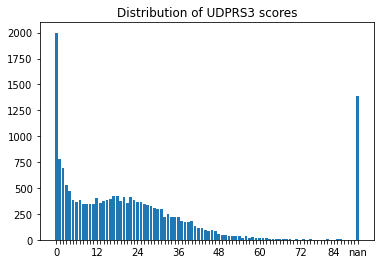

In [200]:
fig, ax = plt.subplots()
dist = updrs3.groupby(["NP3TOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of UDPRS3 scores")
reformat_plot_labels(dist, ax, 12)

### Geriatric Depression Scale Short version (GDS)
Due to the absence of data on Hamilton Depression Scale, we will be using Geriatric Depression Scale. 

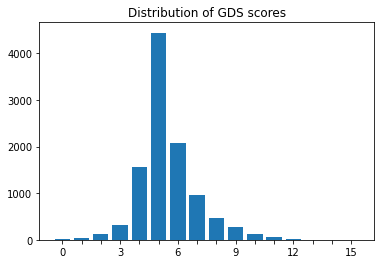

In [201]:
gds = pd.read_csv(
    os.path.join(data_dir, "Geriatric_Depression_Scale__Short_Version_.csv")
)
gds["GDSTOT"] = gds.drop(
    ["PATNO", "EVENT_ID", "REC_ID", "PAG_NAME", "INFODT", "LAST_UPDATE", "ORIG_ENTRY"],
    axis=1,
).sum(axis=1)
gds = gds[["PATNO", "EVENT_ID", "GDSTOT"]]

fig, ax = plt.subplots()
dist = gds.groupby(["GDSTOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of GDS scores")
reformat_plot_labels(dist, ax, 3)

### Levodopa daily equivalent dosage (LEDD)
*TODO*

In [202]:
ledd = pd.read_csv(os.path.join(data_dir, "LEDD_Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "LEDD"]
]

# TODO interpret expression entries for LEDD as values

### Demographics

### Sex

In [203]:
dem = pd.read_csv(os.path.join(data_dir, "Demographics.csv"))[["PATNO", "SEX"]]
dem["SEX"] = dem["SEX"].astype(int)
print(
    "Distribution of Sex\n"
    + dem.groupby("SEX").size().rename({0: "Female", 1: "Male"}).to_string()
)

Distribution of Sex
SEX
Female     998
Male      1352


### Age at visit
We consider the age at specific visits (baseline and 36 months). However for simplicity, we only plot the age distribution at baseline.

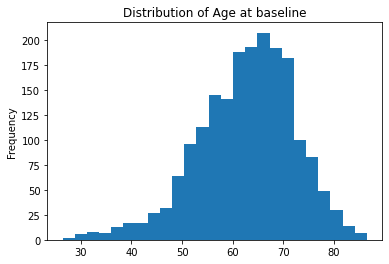

In [204]:
age = pd.read_csv(os.path.join(data_dir, "Age_at_visit.csv"))[
    ["PATNO", "EVENT_ID", "AGE_AT_VISIT"]
]
age[age["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(
    bins=25, title="Distribution of Age at baseline", grid=False
);

### Education
We only use the education years at screening as most of the other visits do not have records of it and most likely didn't change. In addition, when present, the education years at further visits showed inconsistency limiting the possibility to perform data imputation.

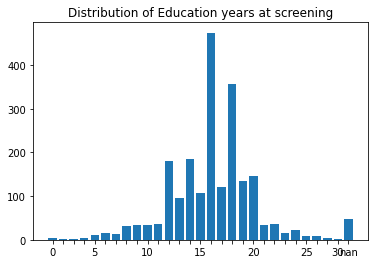

In [205]:
socio = pd.read_csv(os.path.join(data_dir, "Socio-Economics.csv"))[
    ["PATNO", "EVENT_ID", "EDUCYRS"]
]
socio = socio[socio["EVENT_ID"] == "SC"]
socio = socio.drop(["EVENT_ID"], axis=1)

fig, ax = plt.subplots()
dist = socio.groupby(["EDUCYRS"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of Education years at screening")
reformat_plot_labels(dist, ax, 5)

### Data aggregation
We merge the data processed above to obtain a set of data with available:
- Duration of illness
- MMSE, H&Y, UPDRS III, and GDS scores
- Sex, age at visit, and education

In [206]:
keys = ['PATNO', 'EVENT_ID']
df = (
    mmse.merge(pdxdur, on=keys)
    .merge(updrs3, on=keys)
#     .merge(gds, on=keys)  # Might need to get rid of gds as merging it 
    .merge(dem, on=['PATNO'])
    .merge(age, on=keys)
    .merge(socio, on=['PATNO'])
    .drop_duplicates()
    .groupby('PATNO')
    .filter(lambda x: x['EVENT_ID'].nunique() > 1)
)

pde_patno = df[df['DOI'] == 'PD-early']['PATNO']
pdm_patno = df[df['DOI'] == 'PD-middle']['PATNO']
pdl_patno = df[df['DOI'] == 'PD-late']['PATNO']

<div class="alert alert-block alert-warning">
Note: Patients are divided into subgroups at baseline and can not transition from one subgroup to another in the following visits.
</div>

In [207]:
print('Unique number of patients:', df['PATNO'].nunique())
print('Unique number of patients with PD-early:', pde_patno.nunique())
print('Unique number of patients with PD-middle:', pdm_patno.nunique())
print('Unique number of patients with PD-late:', pdm_patno.nunique())

print('\n' + df.groupby(['DOI', 'EVENT_ID'])['PATNO'].nunique().to_string())

Unique number of patients: 1271
Unique number of patients with PD-early: 427
Unique number of patients with PD-middle: 637
Unique number of patients with PD-late: 637

DOI        EVENT_ID
PD-early   PW            1
           SC          427
           V01           1
           V03           1
           V04           1
PD-late    SC           18
           ST            1
           V04          49
           V05           1
           V06          61
           V08          62
           V10          89
           V12         118
           V13         279
           V14         247
           V15         137
           V16         100
           V17          78
           V18          25
PD-middle  PW            2
           RS1           4
           SC          165
           ST           44
           U01           1
           V03           1
           V04         561
           V05           1
           V06         500
           V08         419
           V10         342
  

<div class="alert alert-block alert-danger">
Issue: There isn't any patient data available for baseline.
</div>

<div class="alert alert-block alert-success">
Partial solution: We could use data at screening as substitute for baseline. However, the amount of patients in PD<sub>L</sub> is lower than initial study (24).
</div>